## Imports

In [1]:
import os
import math
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from read_data import *

## Set Styles for transfer

In [2]:
styles = {
    0 : 'Gorodets',
    1 : 'Gzhel',
    2 : 'Iznik',
    3 : 'Khokhloma',
    4 : 'Neglyubka',
    5 : 'Wycinanki_Å‚owickie',
    6 : 'Wzory_kaszubskie'
}

style_X = styles[1]
style_Y = styles[4]

## Set saving / restoring

In [3]:
restoring_mode = False
saving_mode = False

restoring_name = 'first_model.ckpt'
saving_name = 'first_model.ckpt'

restoring_path = os.path.join('models', style_X + ' =|= ' + style_Y, restoring_name)
saving_path = os.path.join('models', style_X + ' =|= ' + style_Y, saving_name)

## Adjust Hyperparameters

In [4]:
EPOCHS = 1
BATCH_SIZE = 1
IMG_SIZE = 150

## Neural Network functions

### Convolution Layers

In [5]:
def conv_layer(X, filters, filter_size, stride, name, activation=None):
    """Create a new convolution layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()
    
        # create the parameter structures         
        W = tf.get_variable(initializer=init, 
                            shape=(filter_size[0], filter_size[1],
                                   in_channels, filters),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
        
        # perform convolution and add bias
        conv = tf.nn.conv2d(X, W, strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)
        
        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        elif activation == "sigmoid":
            return tf.nn.sigmoid(z)
        else:
            return z
     

def deconv_layer(X, filters, filter_size, stride, output_shape, name, activation=None):
    """Create a new deconvolution layer with Xavier initializer"""

    with tf.variable_scope(name):

        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()

        # create the parameter structures         
        W = tf.get_variable(initializer=init,
                            shape=(filter_size[0], filter_size[1],
                                   filters, in_channels),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")

        # perform convolution and add bias
        conv = tf.nn.conv2d_transpose(X, W, output_shape=output_shape,
                                      strides=(1, stride, stride, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)

        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z
        
        
def residual_layer(X, filter_size, stride, name, activation=None):
    """Create a new residual convolution layer with Xavier initializer"""
    
    # get number of input filters     
    filters = in_channels = int(X.get_shape()[3])
    
    # add residuals to convolution     
    z = X + conv_layer(X, filters, filter_size, stride, name)

    # activation function
    if activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

## Build the model and deploy it on a device

In [6]:
with tf.device('/cpu:0'):
    
    #==================[ READ AND PROCESS THE INPUT ]==================#
            
    # load training data from input queues     
    X = inputs(style_X, BATCH_SIZE, EPOCHS)
    Y = inputs(style_Y, BATCH_SIZE, EPOCHS)
    
    # normalize the images     
    X = (tf.cast(X, tf.float32) / 255.0)
    Y = (tf.cast(Y, tf.float32) / 255.0)

### Generators

In [7]:
with tf.device('/gpu:0'):
    
    #==================[ G(X) -> Y ]==================#
    
    X_conv_1 = conv_layer(X, 32, (9, 9), 1, "X_conv_1", "relu")
    X_conv_2 = conv_layer(X_conv_1, 64, (3, 3), 2, "X_conv_2", "relu")
    X_conv_3 = conv_layer(X_conv_2, 128, (3, 3), 2, "X_conv_3", "relu")
    
    X_res_1 = residual_layer(X_conv_3, (1, 1), 1, "X_res_1", "relu")
    X_res_2 = residual_layer(X_res_1, (1, 1), 1, "X_res_2", "relu")
    X_res_3 = residual_layer(X_res_2, (1, 1), 1, "X_res_3", "relu")
    
    X_deconv_2 = deconv_layer(X_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "X_deconv_2", "relu")
    X_deconv_1 = deconv_layer(X_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "X_deconv_1", "relu")
    G_x = deconv_layer(X_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "G_x", "relu")
    
    #==================[ F(Y) -> X ]==================#
    
    Y_conv_1 = conv_layer(Y, 32, (9, 9), 1, "Y_conv_1", "relu")
    Y_conv_2 = conv_layer(Y_conv_1, 64, (3, 3), 2, "Y_conv_2", "relu")
    Y_conv_3 = conv_layer(Y_conv_2, 128, (3, 3), 2, "Y_conv_3", "relu")
    
    Y_res_1 = residual_layer(Y_conv_3, (1, 1), 1, "Y_res_1", "relu")
    Y_res_2 = residual_layer(Y_res_1, (1, 1), 1, "Y_res_2", "relu")
    Y_res_3 = residual_layer(Y_res_2, (1, 1), 1, "Y_res_3", "relu")
    
    Y_deconv_2 = deconv_layer(Y_res_3, 64, (3, 3), 2, [BATCH_SIZE, 75, 75, 64], "Y_deconv_2", "relu")
    Y_deconv_1 = deconv_layer(Y_deconv_2, 32, (3, 3), 2, [BATCH_SIZE, 150, 150, 32], "Y_deconv_1", "relu") 
    F_y = deconv_layer(Y_deconv_1, 3, (9, 9), 1, [BATCH_SIZE, 150, 150, 3], "F_y", "relu")
        

### Discriminators

In [8]:
with tf.device('/gpu:0'):
    
    #==================[ Dy ]==================#
    
    Dy_input = tf.concat([G_x, Y])
    Dy_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1])
    
    Dy_conv_1 = conv_layer(Dy_input, 32, (3, 3), 1, "Dy_conv_1", "relu")
    Dy_conv_2 = conv_layer(Dy_conv_1, 32, (3, 3), 1, "Dy_conv_2", "relu")
    Dy_conv_3 = conv_layer(Dy_conv_2, 1, (5, 5), 5, "Dy_conv_3", "sigmoid")
    Dy = tf.reduce_mean(Dy_conv_3, 0, name="Dy")
    
    #==================[ Dx ]==================#
    
    Dx_input = tf.concat([F_y, X])
    Dx_labels = tf.constant(BATCH_SIZE * [0] + BATCH_SIZE * [1])
    
    Dx_conv_1 = conv_layer(Dx_input, 32, (3, 3), 1, "Dx_conv_1", "relu")
    Dx_conv_2 = conv_layer(Dx_conv_1, 32, (3, 3), 1, "Dx_conv_2", "relu")
    Dx_conv_3 = conv_layer(Dx_conv_2, 1, (5, 5), 5, "Dx_conv_3", "sigmoid")
    Dx = tf.reduce_mean(Dx_conv_3, 0, name="Dx")
    

## Losses

In [ ]:
# losses

## Create the session and start the threads for input queues

In [9]:
# create the session saver
saver = tf.train.Saver()

# create a session for running operations in the graph.
sess = tf.Session()

# create the variable initializers
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# initialize the variables
sess.run(init_op)

if restoring_mode:
    # previously saved model is restored
    saver.restore(sess, restoring_path)
    
# start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

## Training loop

0.500575


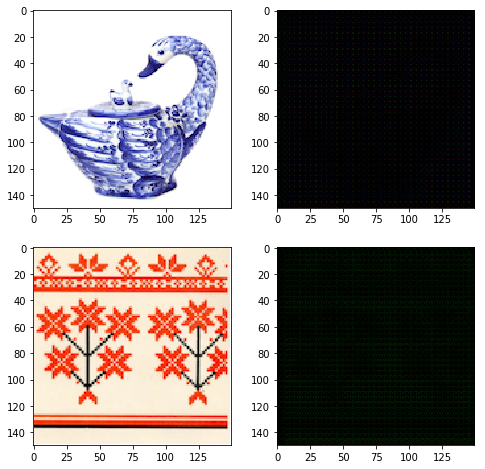

0.500584


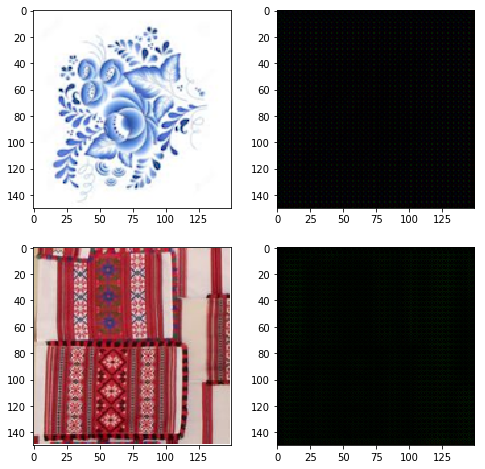

0.500561


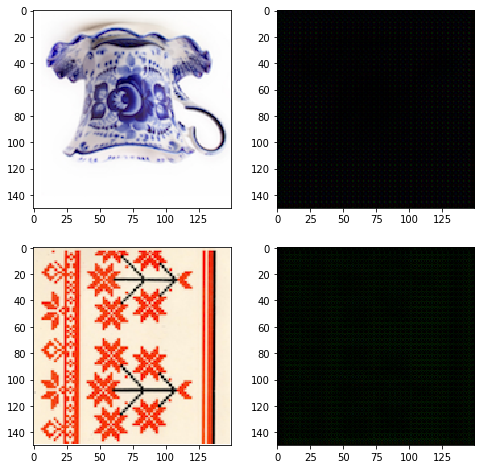

0.500543


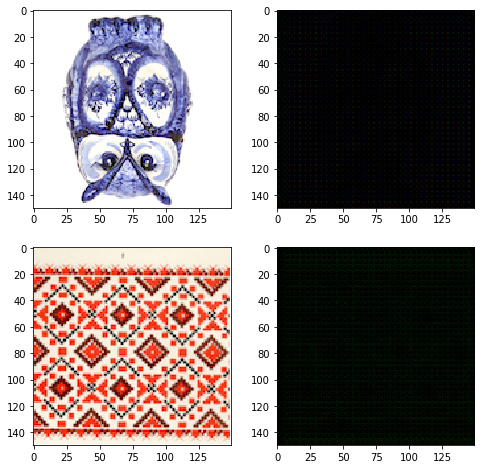

0.500577


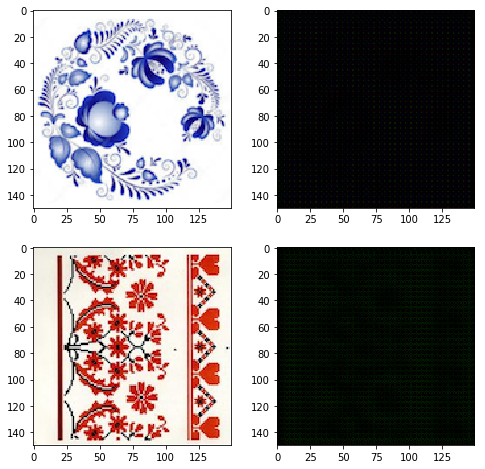

0.500572


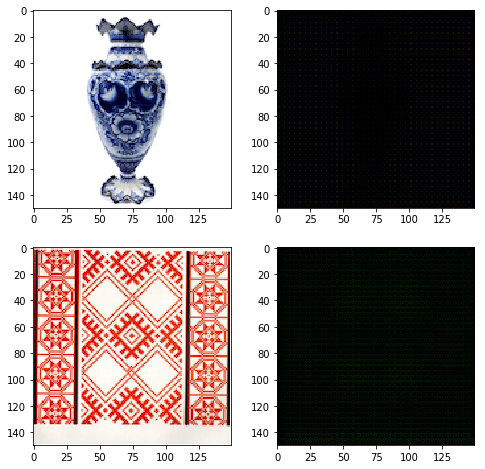

0.50052


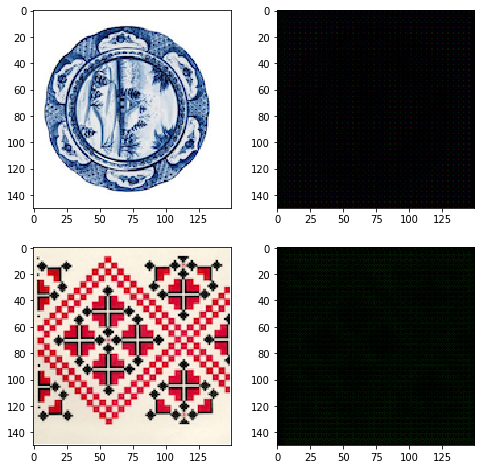

0.500577


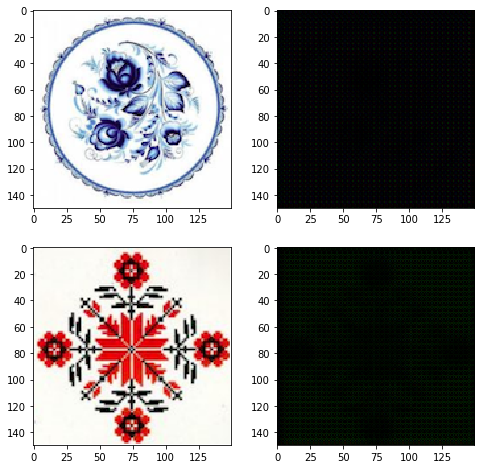

0.500558


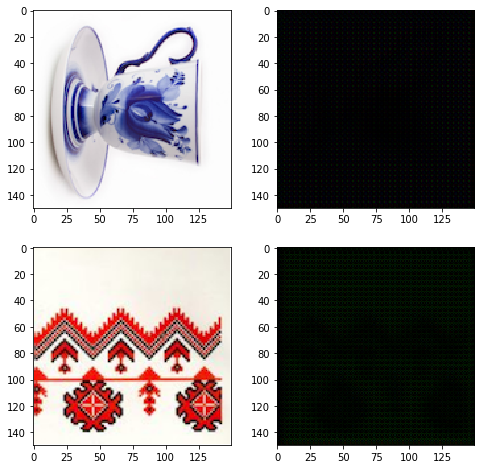

0.500597


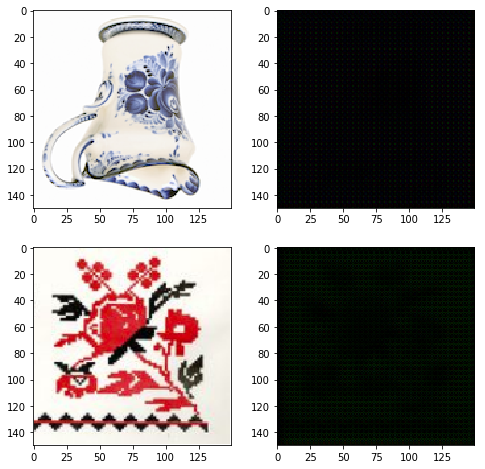

0.500545


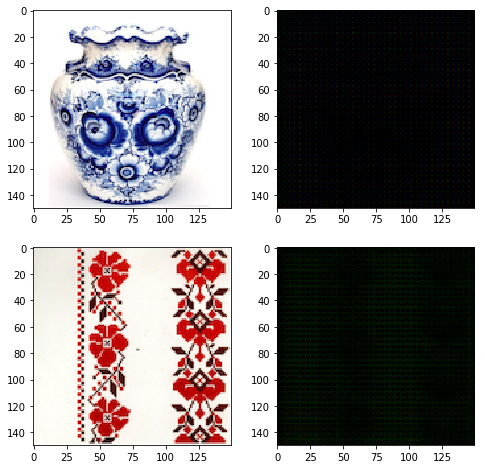

0.50058


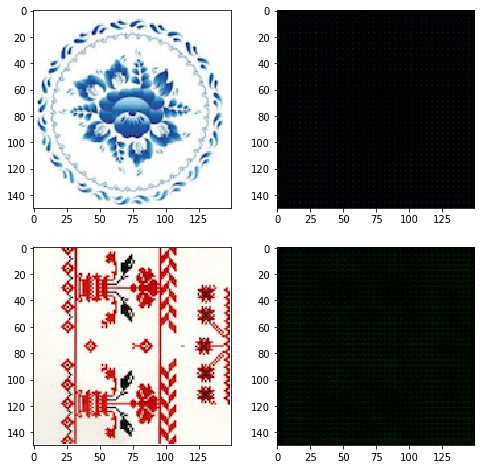

0.50057


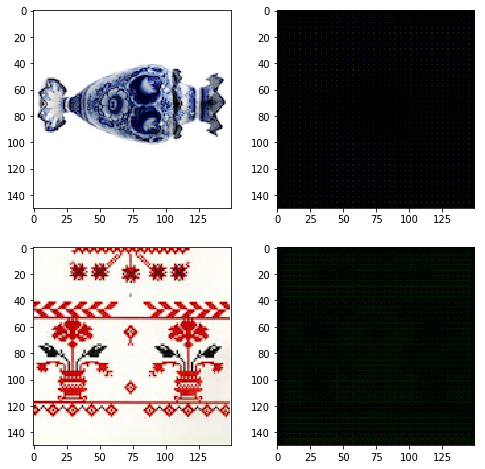

0.500553


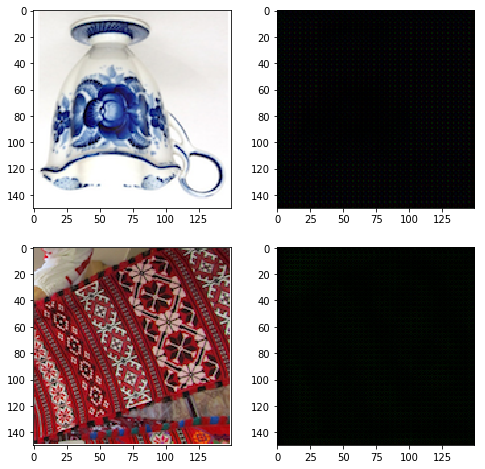

0.500531


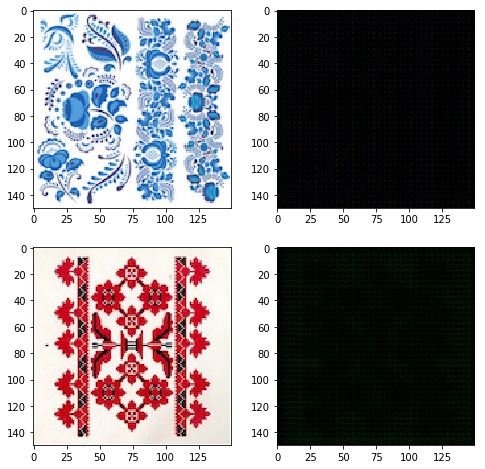

0.500536


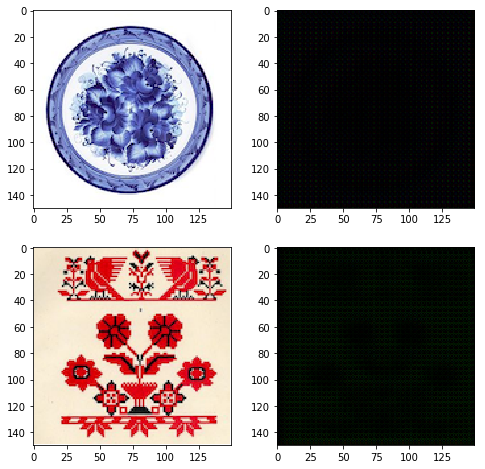

0.50058


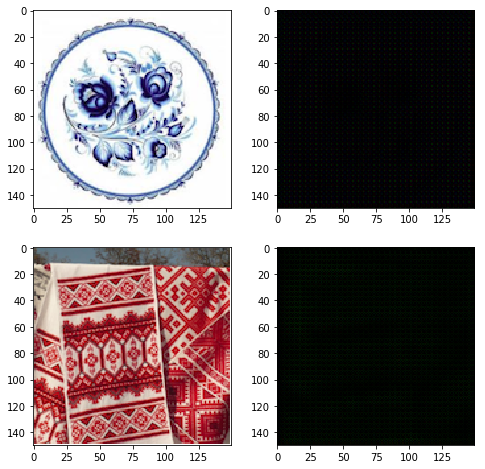

0.500561


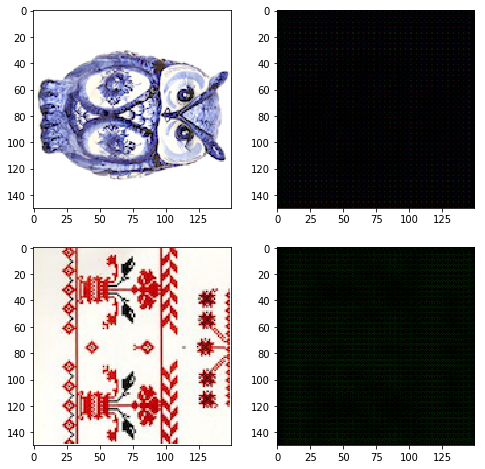

0.500551


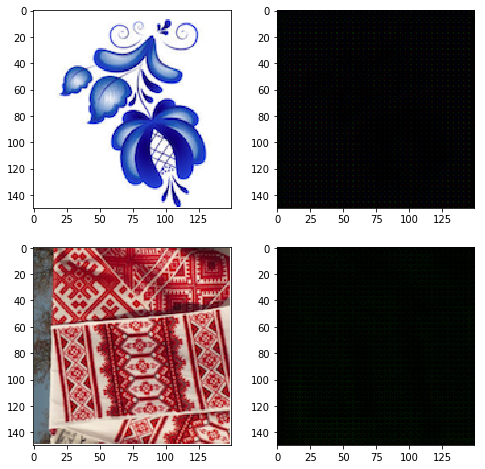

0.500602


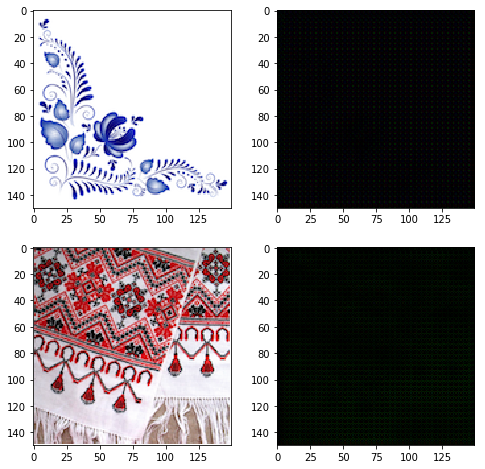

0.500536


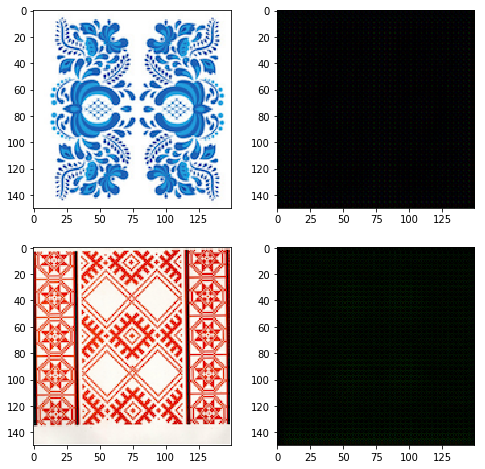

0.500554


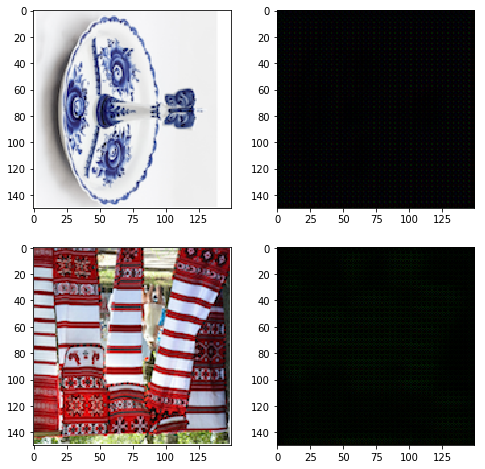

0.500598


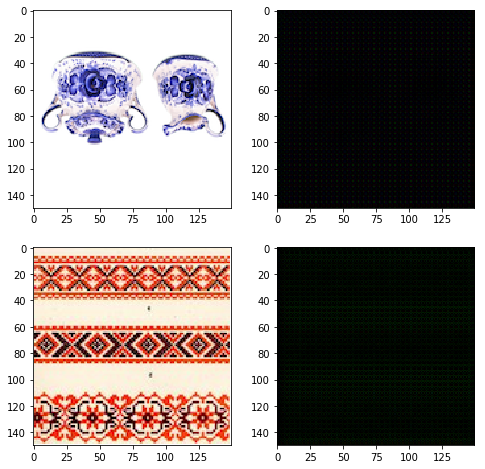

0.500573


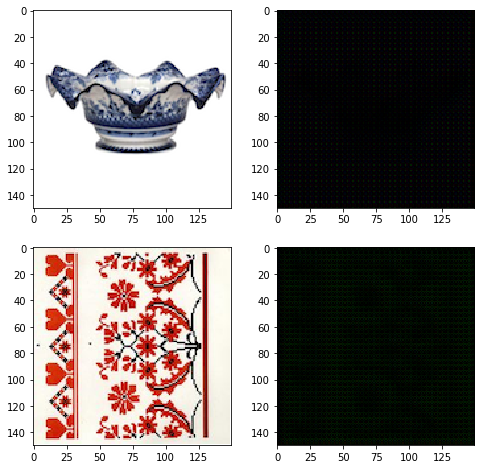

0.500607


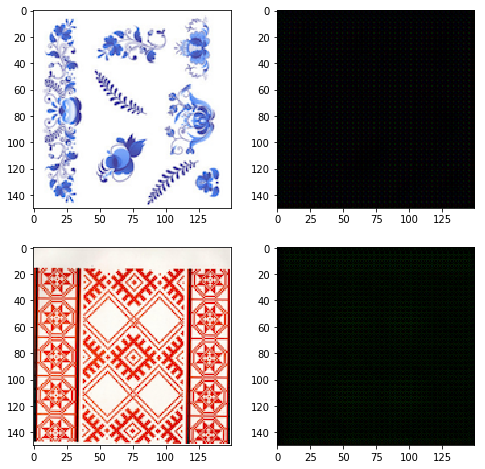

0.500609


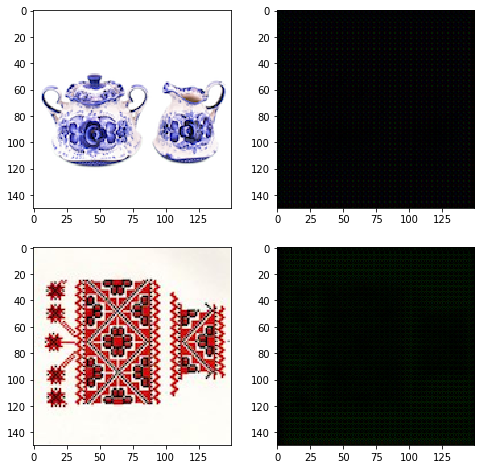

0.500575


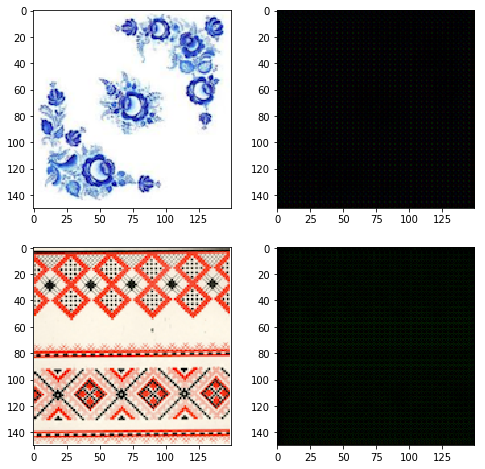

0.500567


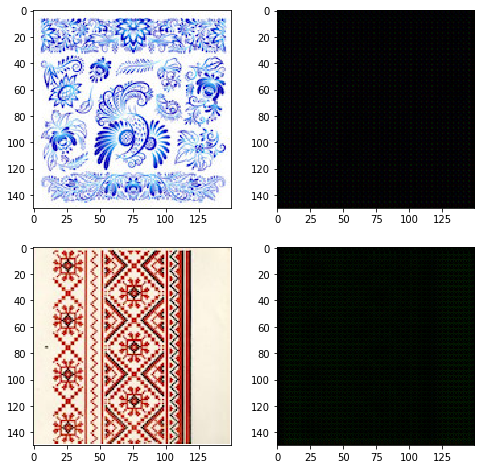

0.500555


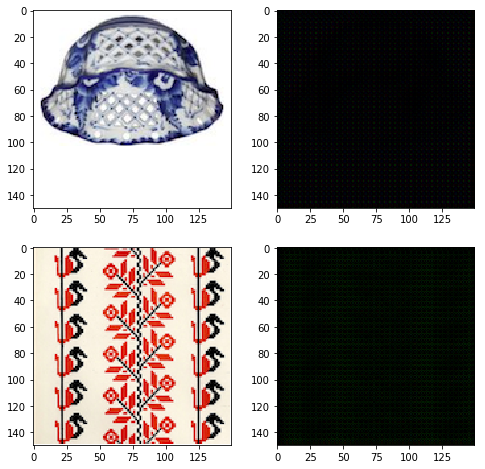

0.500557


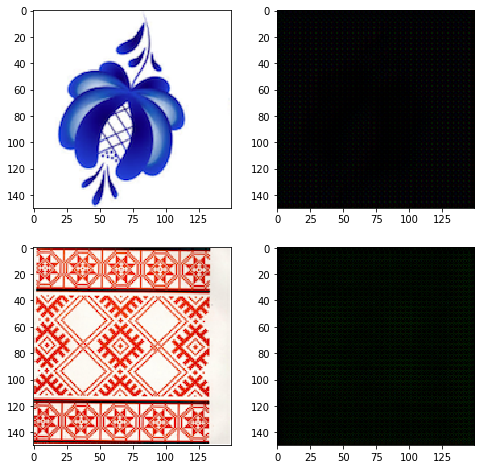

0.50053


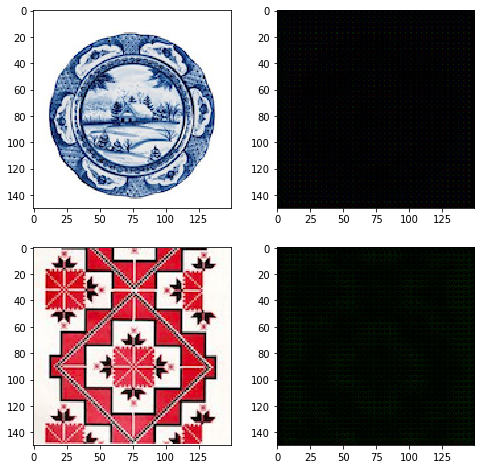

0.500543


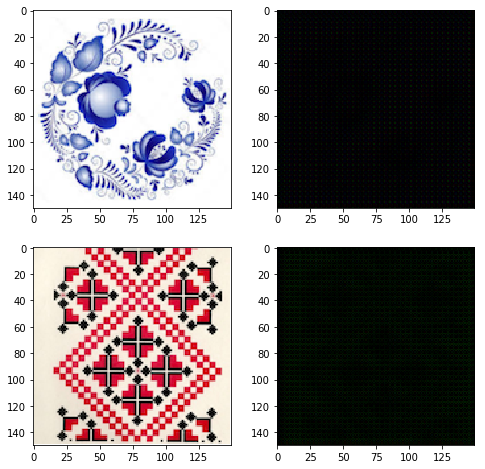

0.500576


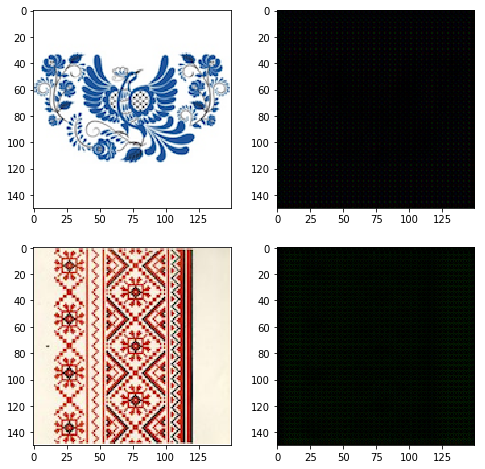

0.500577


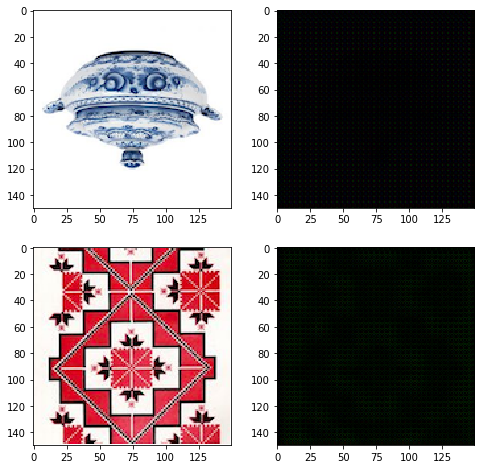

0.500573


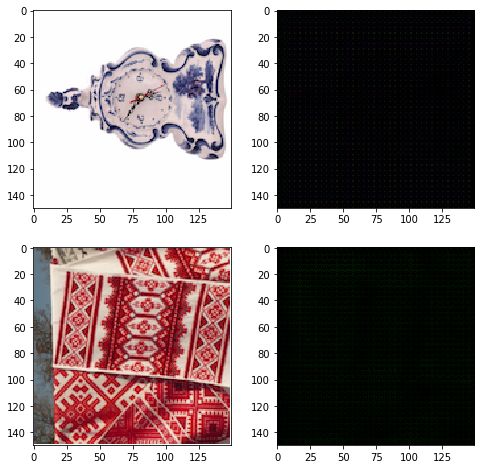

0.500575


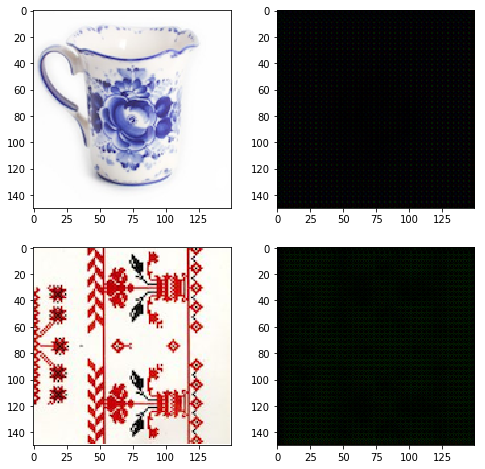

0.50057


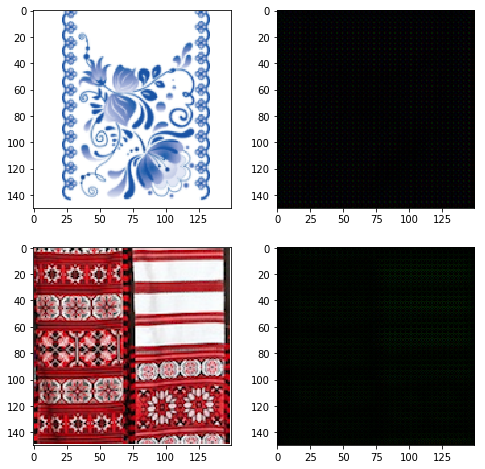

0.50057


KeyboardInterrupt: 

In [10]:
try:
    step = 0   
    # feed data until the epoch limit is reached     
    while not coord.should_stop():
        step += 1
        x, g_x, y, f_y, d_y = sess.run([X, G_x, Y, F_y, Dy])
        print(d_y)
        fig=plt.figure(figsize=(8, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow(x[0, :, :, :3])
        fig.add_subplot(2, 2, 2)
        plt.imshow(g_x[0, :, :, :3])
        fig.add_subplot(2, 2, 3)
        plt.imshow(y[0, :, :, :3])
        fig.add_subplot(2, 2, 4)
        plt.imshow(f_y[0, :, :, :3])
        plt.show()
        
        
except tf.errors.OutOfRangeError:
    
    print('\nDone training -- epoch limit reached\n')
    
finally:
    
    # when done, ask the threads to stop
    coord.request_stop()

    # wait for threads to finish
    coord.join(threads)
    sess.close()